In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

# Specify the file path
file_path = "Merged_Aneurysm.csv"

# Load the CSV file into a Pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data has been loaded correctly
data.head()


,case_id,patient_id,aneurysmLocation,aneurysmType,ruptureStatus,age,sex,multipleAneurysms,sacVolume,sacSurfaceArea,...,maxPressure,meanPressure,maxSpeed,meanSpeed,minTAWSS,maxTAWSS,meanTAWSS,minOSI,maxOSI,meanOSI
0,C0001,P0085,ICA,LAT,U,53,F,False,125.259604,120.453515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C0002,P0112,ICA,LAT,U,35,F,False,119.002032,122.427263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C0003,P0115,ICA,TER,U,43,F,False,12.740609,23.480617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C0004,P0116,ICA,TER,U,60,F,True,9.376307,18.084625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C0005,P0118,ICA,LAT,R,26,F,False,37.934454,54.844592,...,7665.0,3722.28,70.275319,13.19376,0.31251,176.44,20.90888,0.0,0.44672,0.001574


In [97]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Define the list of characteristics to be used
characteristics = [
    'age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea', 
    'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis', 
    'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength', 
    'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize', 
    'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star', 'sizeRatio_star', 
    'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle', 'meanRadius', 
    'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius', 'maxRadius', 
    'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane', 
    'bifurcationAngleOutOfPlane', 'aneurysmLocation', 'aneurysmType'
]

# Subset the data to include only the specified characteristics and the target variable
data_subset = data[characteristics + ['ruptureStatus']]

# Separate the target variable
X = data_subset.drop(columns=['ruptureStatus'])
y = data_subset['ruptureStatus']

# Handle missing values for numerical and categorical features separately
numerical_columns = X.select_dtypes(include=np.number).columns
categorical_columns = X.select_dtypes(exclude=np.number).columns

# Impute missing values for numerical columns
imputer_numerical = SimpleImputer(strategy='mean')
X[numerical_columns] = imputer_numerical.fit_transform(X[numerical_columns])


# Encode categorical variables
if not categorical_columns.empty:
    encoder = OneHotEncoder(drop='first', sparse=False)
    encoded_categorical = encoder.fit_transform(X[categorical_columns])
    encoded_categorical_columns = encoder.get_feature_names_out(categorical_columns)
    X = pd.concat([X.drop(columns=categorical_columns).reset_index(drop=True), 
                   pd.DataFrame(encoded_categorical, columns=encoded_categorical_columns)], axis=1)

# Encode the target variable
y_encoded = y.map({'R': 1, 'U': 0}).astype(int)

# Feature Scaling for X (numerical and encoded categorical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preprocessing complete!")


Data preprocessing complete!


In [98]:
# Create a mapping of original labels to their encoded values
mapping = {original: encoded for original, encoded in zip(y, y_encoded)}

# Display the mapping
print("Mapping of original labels to encoded values:")
print(mapping)

# Alternatively, create a DataFrame to inspect individual mappings
mapping_df = pd.DataFrame({'Original': y, 'Encoded': y_encoded})
print(mapping_df)


Mapping of original labels to encoded values:
{'U': 0, 'R': 1}
    Original  Encoded
0          U        0
1          U        0
2          U        0
3          U        0
4          R        1
..       ...      ...
98         U        0
99         R        1
100        R        1
101        R        1
102        U        0

[103 rows x 2 columns]


In [99]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_BAS',
       'aneurysmLocation_ICA', 'aneurysmLocation_MCA', 'aneurysmType_TER'],
      dtype='object')

In [100]:
import sklearn

# Print the version of scikit-learn
sklearn.__version__

'1.1.3'

In [101]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_scaled, y_encoded)
xgb_model = grid_search.best_estimator_
xgb_model


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecate

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions using cross-validation for the best model
y_pred_prob_best = cross_val_predict(best_model, X_scaled, y_encoded, cv=3, method='predict_proba')[:, 1]

# Calculate AUC-ROC for the best model
auc_roc_best = roc_auc_score(y_encoded, y_pred_prob_best)

# Print the best model's parameters and its AUC-ROC
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
print(f"AUC-ROC Score: {auc_roc_best:.3f}")


Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean Cross-Validation Accuracy: 0.709
AUC-ROC Score: 0.714


`use_label_encoder` is deprecated in 1.7.0.


In [103]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_scaled)

# Compute SHAP values
shap_values = explainer(X_scaled)

print("SHAP values computation complete!")


SHAP values computation complete!


HDBSCAN Clustering complete!


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


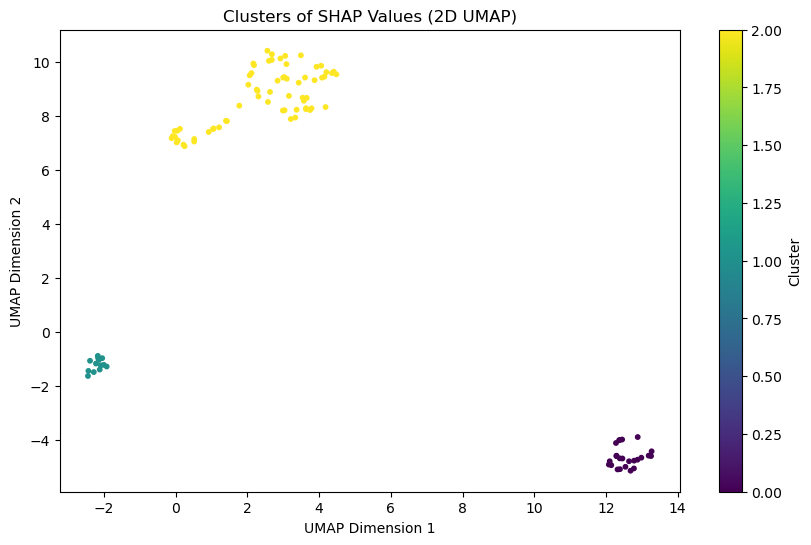

In [104]:
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# Dimensionality reduction using UMAP with fixed randomness
shap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0, random_state=42).fit_transform(shap_values.values)

# Clustering using HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
cluster_labels = hdbscan.fit_predict(shap_2d)

print("HDBSCAN Clustering complete!")

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(shap_2d[:, 0], shap_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(label="Cluster")
plt.title("Clusters of SHAP Values (2D UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [144]:
from sklearn.metrics import silhouette_score

score = silhouette_score(shap_2d, cluster_labels)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.8582625389099121


In [106]:
import pandas as pd

cluster_data = pd.DataFrame(shap_values.values, columns=X.columns)


label_mapping = {0: 'α', 1: 'β', 2: 'γ'}  # Adjust as per your cluster count
cluster_labels = np.vectorize(label_mapping.get)(cluster_labels)
cluster_data['Cluster'] = cluster_labels
print(cluster_data.groupby('Cluster').mean())


              age  sacVolume  sacSurfaceArea  vdcVolume  vdcSurfaceArea  \
Cluster                                                                   
α       -0.024268        0.0             0.0   0.015644             0.0   
β        0.002909        0.0             0.0   0.004815             0.0   
γ        0.003593        0.0             0.0  -0.007287             0.0   

         sacSectionArea  ellipsoidVolume  ellipsoidMaxSemiaxis  \
Cluster                                                          
α             -0.110991        -0.079248              0.010991   
β              0.003858        -0.000735              0.004135   
γ              0.040285         0.026342             -0.004615   

         ellipsoidMidSemiaxis  ellipsoidMinSemiaxis  ...  minRadius  \
Cluster                                              ...              
α                   -0.132224                   0.0  ...  -0.072936   
β                    0.013414                   0.0  ...   0.203433   
γ        

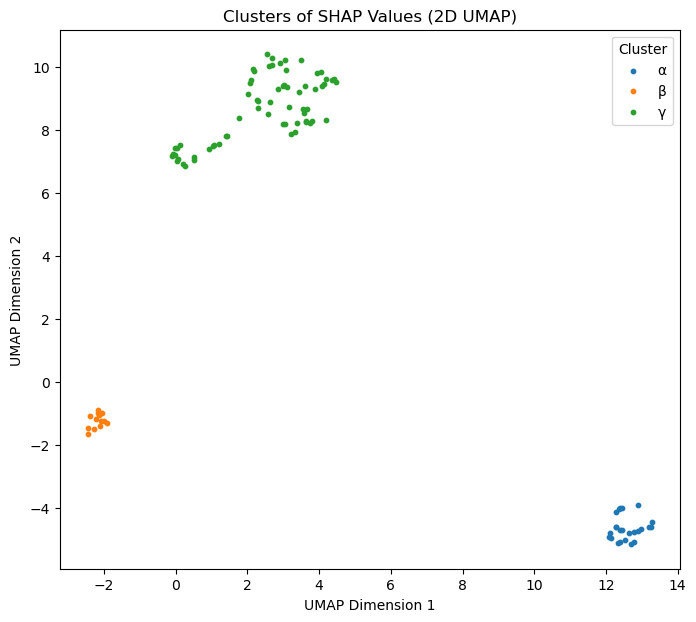

In [107]:
# Scatter plot of clusters with descriptive labels
plt.figure(figsize=(8, 7))
for cluster in np.unique(cluster_labels):
    indices = cluster_labels == cluster
    plt.scatter(
        shap_2d[indices, 0],
        shap_2d[indices, 1],
        label=cluster,
        s=10
    )
plt.title("Clusters of SHAP Values (2D UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [108]:
import pandas as pd

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Add cluster labels to the SHAP DataFrame
shap_df['Cluster'] = cluster_labels


In [109]:
# Group by clusters and calculate mean SHAP values
cluster_means = shap_df.groupby('Cluster').mean()

# Display the top SHAP features for each cluster
print(cluster_means.T)


Cluster                            α         β         γ
age                        -0.024268  0.002909  0.003593
sacVolume                   0.000000  0.000000  0.000000
sacSurfaceArea              0.000000  0.000000  0.000000
vdcVolume                   0.015644  0.004815 -0.007287
vdcSurfaceArea              0.000000  0.000000  0.000000
sacSectionArea             -0.110991  0.003858  0.040285
ellipsoidVolume            -0.079248 -0.000735  0.026342
ellipsoidMaxSemiaxis        0.010991  0.004135 -0.004615
ellipsoidMidSemiaxis       -0.132224  0.013414  0.039878
ellipsoidMinSemiaxis        0.000000  0.000000  0.000000
sacCenterlineLength         0.013925  0.004591 -0.005360
ostiumSectionArea           0.000000  0.000000  0.000000
ostiumSectionPerimeter      0.001244  0.002344 -0.000937
ostiumMinSize              -0.025742  0.041647  0.003590
ostiumMaxSize               0.000000  0.000000  0.000000
ostiumShapeFactor          -0.004458  0.005847  0.002674
aspectRatio_star           -0.0

In [110]:
y_encoded

0      0
1      0
2      0
3      0
4      1
      ..
98     0
99     1
100    1
101    1
102    0
Name: ruptureStatus, Length: 103, dtype: int32

In [111]:
import pandas as pd
from scipy.stats import chi2_contingency

# Cluster and rupture status data
cluster_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'RuptureStatus': y_encoded  # Assuming y_encoded corresponds to ruptureStatus
})

# Calculate rupture proportions by cluster
rupture_distribution = cluster_df.groupby('Cluster')['RuptureStatus'].mean()
cluster_sizes = cluster_df.groupby('Cluster')['RuptureStatus'].size()

# Create a contingency table for statistical testing
contingency_table = pd.crosstab(cluster_df['Cluster'], cluster_df['RuptureStatus'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

rupture_distribution, cluster_sizes, p_value


(Cluster
 α    0.041667
 β    1.000000
 γ    0.454545
 Name: RuptureStatus, dtype: float64,
 Cluster
 α    24
 β    13
 γ    66
 Name: RuptureStatus, dtype: int64,
 1.0127791801877694e-07)

In [112]:
from scipy.stats import chi2_contingency, fisher_exact
from itertools import combinations

# Get unique cluster pairs
cluster_pairs = list(combinations(cluster_df['Cluster'].unique(), 2))

# Perform pairwise comparisons
results = []
for c1, c2 in cluster_pairs:
    sub_table = pd.crosstab(
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['Cluster'],
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['RuptureStatus']
    )
    if sub_table.values.min() < 5:  # Use Fisher's Exact Test for small counts
        _, p_value = fisher_exact(sub_table)
        test_type = "Fisher"
    else:  # Use Chi-Square for larger counts
        _, p_value, _, _ = chi2_contingency(sub_table)
        test_type = "Chi-Square"
    results.append({'Cluster Pair': (c1, c2), 'p-value': p_value, 'Test': test_type})

# Adjust for multiple comparisons (Bonferroni correction)
bonferroni_alpha = 0.05 / len(results)  # Adjusted significance level

# Output results
for result in results:
    result['Significant'] = result['p-value'] < bonferroni_alpha
    print(result)


{'Cluster Pair': ('α', 'γ'), 'p-value': 0.00012938965419534264, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': ('α', 'β'), 'p-value': 3.929860633387428e-09, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': ('γ', 'β'), 'p-value': 0.00014734260135082858, 'Test': 'Fisher', 'Significant': True}


In [113]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_BAS',
       'aneurysmLocation_ICA', 'aneurysmLocation_MCA', 'aneurysmType_TER'],
      dtype='object')

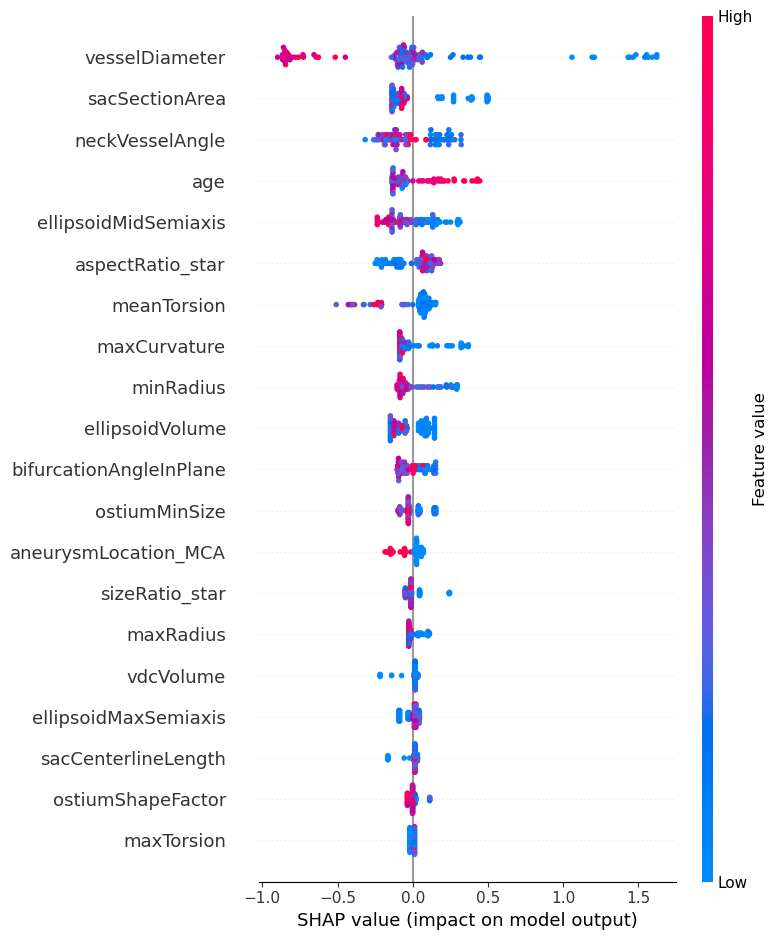

In [114]:
import shap

# Plot the summary plot
shap.summary_plot(shap_values.values, features=X_scaled, feature_names=X.columns)


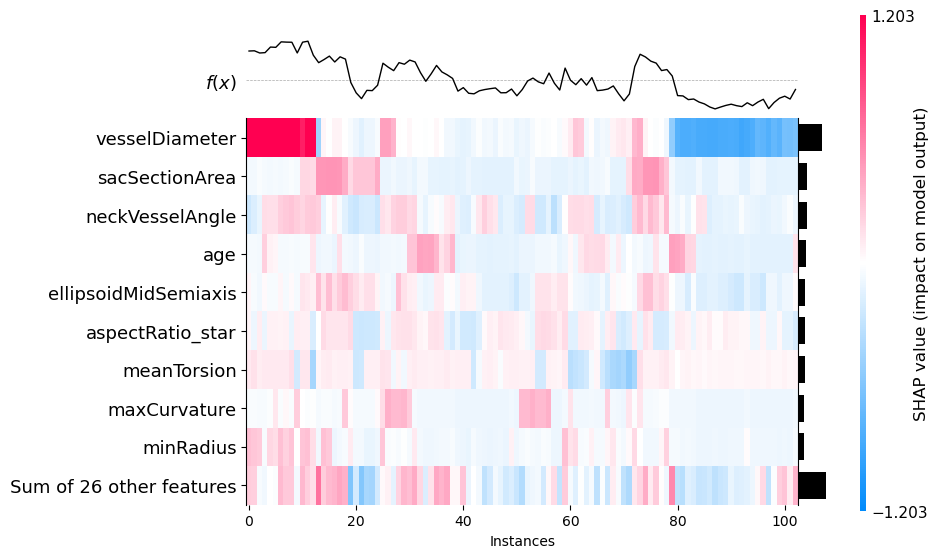

In [115]:
explainer = shap.Explainer(xgb_model, X_scaled, feature_names=X.columns)
shap_values = explainer(X_scaled)

shap.plots.heatmap(shap_values)


In [116]:
# Mean SHAP values by cluster
cluster_summary = cluster_data.groupby('Cluster').mean()
print(cluster_summary)


              age  sacVolume  sacSurfaceArea  vdcVolume  vdcSurfaceArea  \
Cluster                                                                   
α       -0.024268        0.0             0.0   0.015644             0.0   
β        0.002909        0.0             0.0   0.004815             0.0   
γ        0.003593        0.0             0.0  -0.007287             0.0   

         sacSectionArea  ellipsoidVolume  ellipsoidMaxSemiaxis  \
Cluster                                                          
α             -0.110991        -0.079248              0.010991   
β              0.003858        -0.000735              0.004135   
γ              0.040285         0.026342             -0.004615   

         ellipsoidMidSemiaxis  ellipsoidMinSemiaxis  ...  minRadius  \
Cluster                                              ...              
α                   -0.132224                   0.0  ...  -0.072936   
β                    0.013414                   0.0  ...   0.203433   
γ        

In [117]:
# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns
numeric_columns = original_data.select_dtypes(include=np.number)

# Calculate mean feature values for each cluster (true values)
true_cluster_summary = numeric_columns.groupby(original_data['Cluster']).mean()

# Display the mean true values by cluster
print(true_cluster_summary)


               age   sacVolume  sacSurfaceArea   vdcVolume  vdcSurfaceArea  \
Cluster                                                                      
α        57.041667  396.197470      236.427878  363.800078      215.144333   
β        50.846154  163.215660      139.741336  136.739951      113.638379   
γ        54.409091  147.959634      112.825151  134.154519      101.511444   

         sacSectionArea  ellipsoidVolume  ellipsoidMaxSemiaxis  \
Cluster                                                          
α             52.378966       270.135800              4.557338   
β             28.753349        90.370143              3.623238   
γ             24.757552        97.820624              3.183714   

         ellipsoidMidSemiaxis  ellipsoidMinSemiaxis  ...  meanRadius  \
Cluster                                              ...               
α                    3.514313              2.995379  ...    1.991450   
β                    2.276231              1.979831  ...    0.

In [118]:
cluster_df['Prediction'] = xgb_model.predict(X_scaled)
cluster_accuracy = cluster_df.groupby('Cluster').apply(lambda x: (x['Prediction'] == x['RuptureStatus']).mean())
print(cluster_accuracy)


Cluster
α    0.958333
β    1.000000
γ    0.954545
dtype: float64


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [119]:
import shap
import seaborn as sns
shap.initjs()

# Assuming you used StandardScaler for scaling the features
original_values = scaler.inverse_transform(X_scaled[:1000])

# Generate the force plot using original feature values
shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
)

# Save the force plot with original feature values
shap.save_html('force_plot.html', shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
))


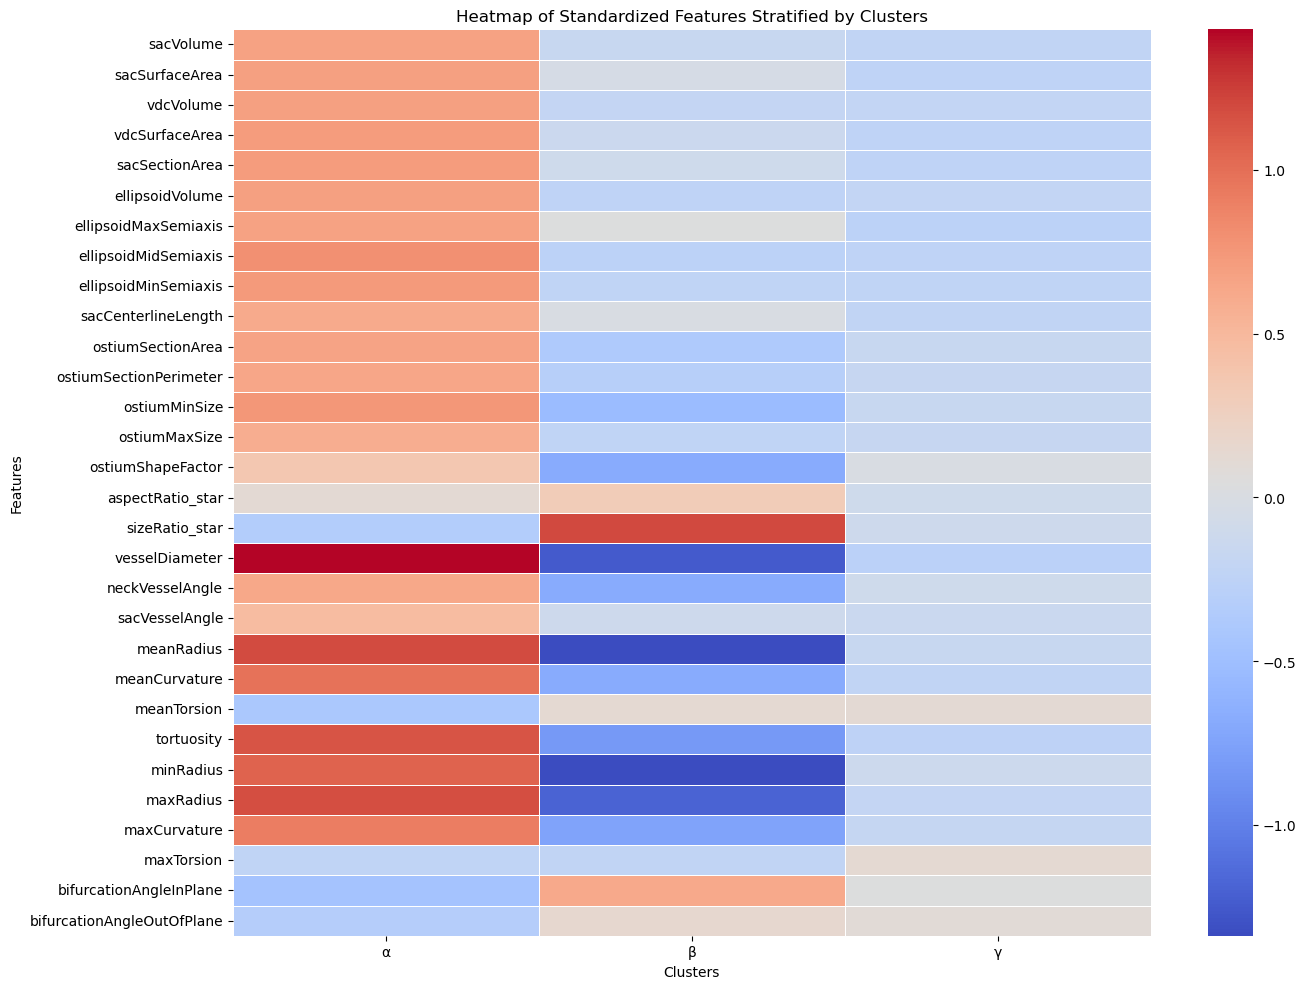

In [120]:
# Dropping specified non-numeric features and 'age' from numeric columns
numeric_features_filtered = original_data.drop(columns=['Cluster', 'aneurysmLocation', 'aneurysmType', 'age'])

# Standardizing the numeric features
standardized_features_filtered = pd.DataFrame(
    scaler.fit_transform(numeric_features_filtered),
    columns=numeric_features_filtered.columns
)

# Adding the cluster labels back to the standardized data
standardized_features_filtered['Cluster'] = original_data['Cluster']

# Calculating the mean of each feature grouped by cluster
cluster_feature_means_filtered = standardized_features_filtered.groupby('Cluster').mean().T

# Creating the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_feature_means_filtered, cmap='coolwarm', annot=False, cbar=True, linewidths=0.5)
plt.title("Heatmap of Standardized Features Stratified by Clusters")
plt.xlabel("Clusters")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [121]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_BAS',
       'aneurysmLocation_ICA', 'aneurysmLocation_MCA', 'aneurysmType_TER'],
      dtype='object')

In [122]:
# Add 'aneurysmLocation' and 'aneurysmType' from the original data to X
X['aneurysmLocation'] = data['aneurysmLocation']
X['aneurysmType'] = data['aneurysmType']

# Drop 'aneurysmLocation_BAS' and 'aneurysmLocation_ICA' to maintain the same number of features
X = X.drop(columns=['aneurysmLocation_BAS', 'aneurysmLocation_ICA'])

# Verify the columns have been updated
print(X.columns)


Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_MCA',
       'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')


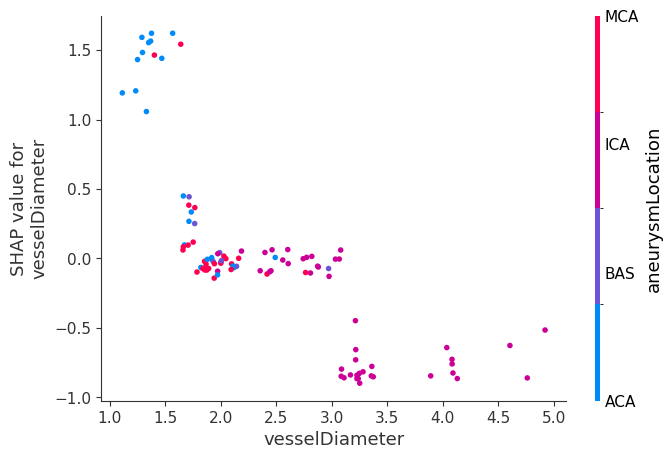

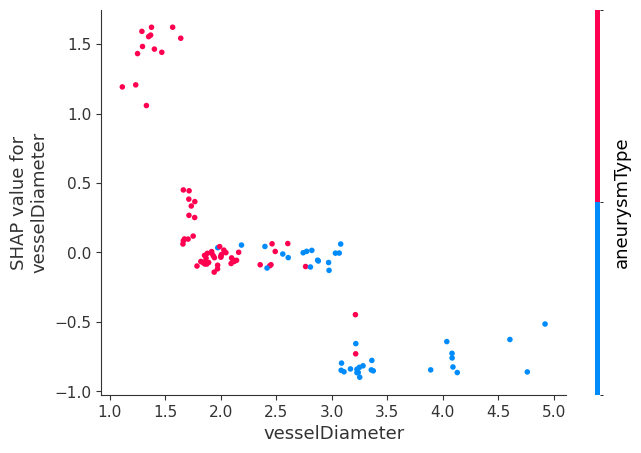

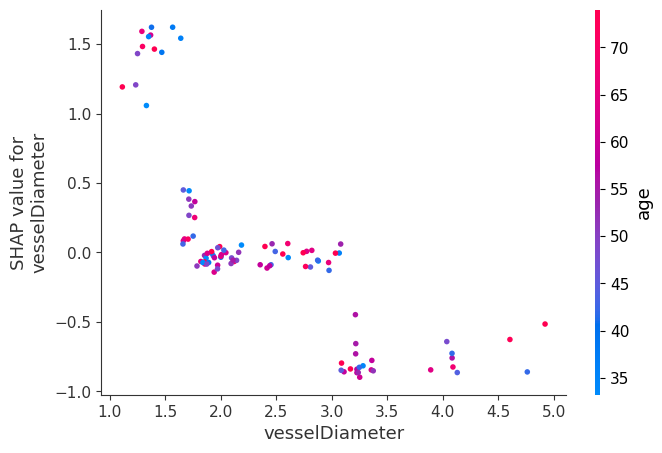

In [123]:
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)

"""
(aneurysmType
 LAT    3.251116
 TER    1.892105
 Name: vesselDiameter, dtype: float64,
 'TER',
 'LAT')
 The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.
"""
shap.dependence_plot('vesselDiameter', shap_values.values, X, interaction_index='age', feature_names=X.columns)


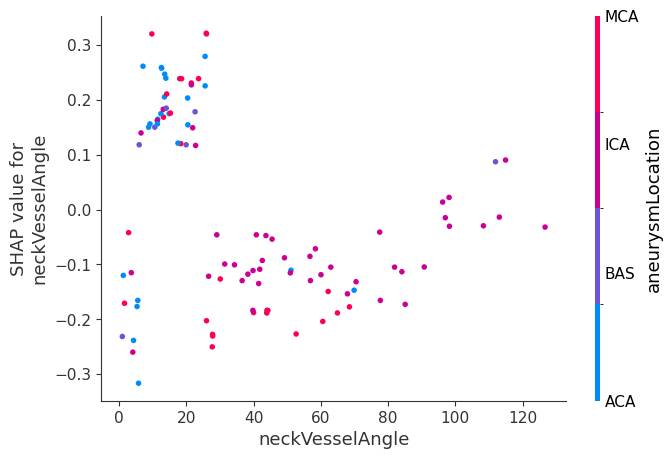

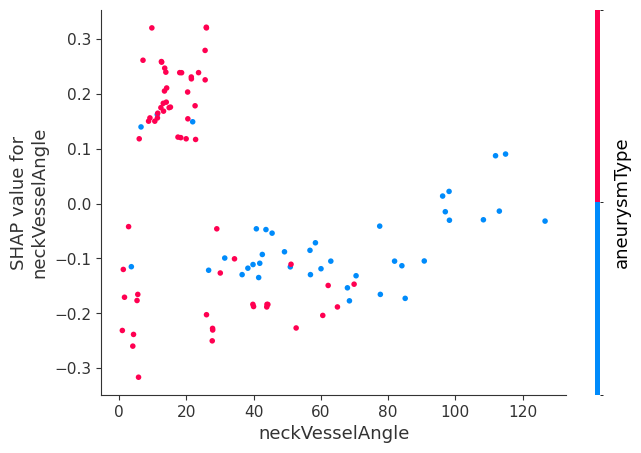

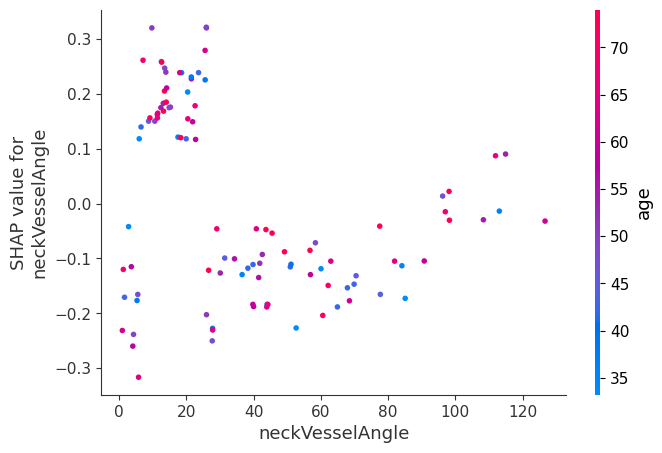

In [124]:
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)

"""
(aneurysmType
 LAT    3.251116
 TER    1.892105
 Name: vesselDiameter, dtype: float64,
 'TER',
 'LAT')
 The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.
"""
shap.dependence_plot('neckVesselAngle', shap_values.values, X, interaction_index='age', feature_names=X.columns)


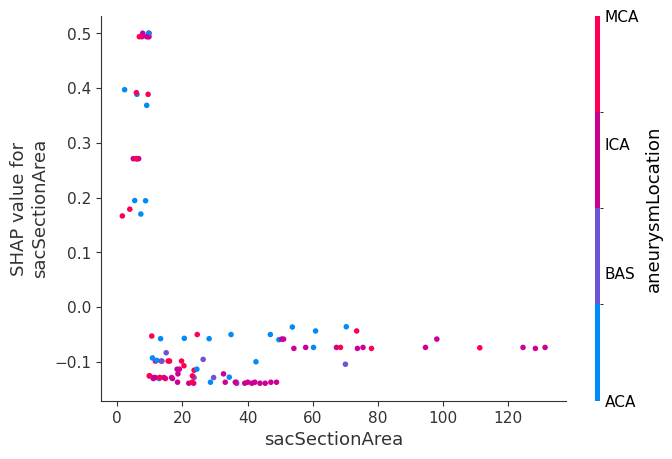

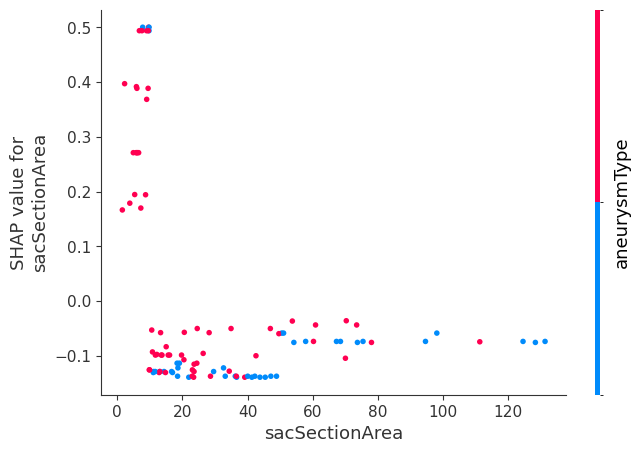

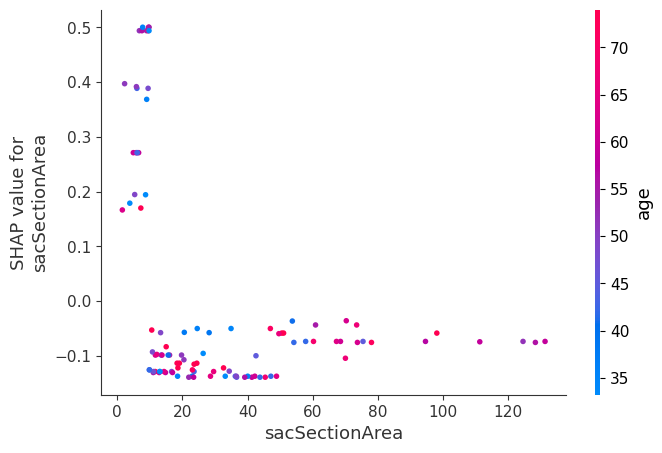

In [125]:
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='aneurysmLocation', feature_names=X.columns)
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='aneurysmType', feature_names=X.columns)

"""
(aneurysmType
 LAT    3.251116
 TER    1.892105
 Name: vesselDiameter, dtype: float64,
 'TER',
 'LAT')
 The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.
"""
shap.dependence_plot('sacSectionArea', shap_values.values, X, interaction_index='age', feature_names=X.columns)


In [126]:
X.columns

Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation_MCA',
       'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')

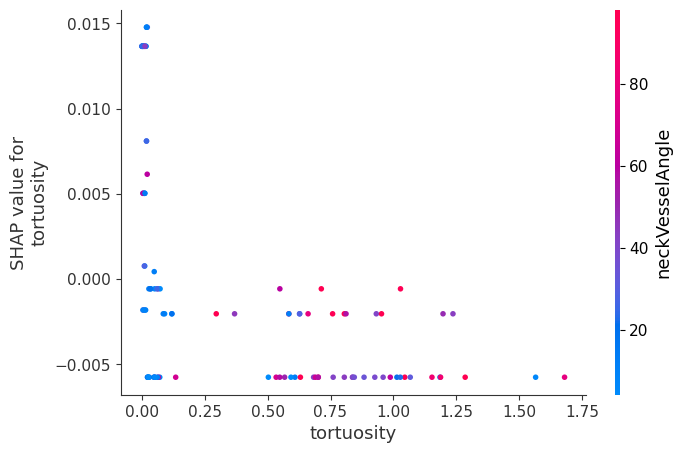

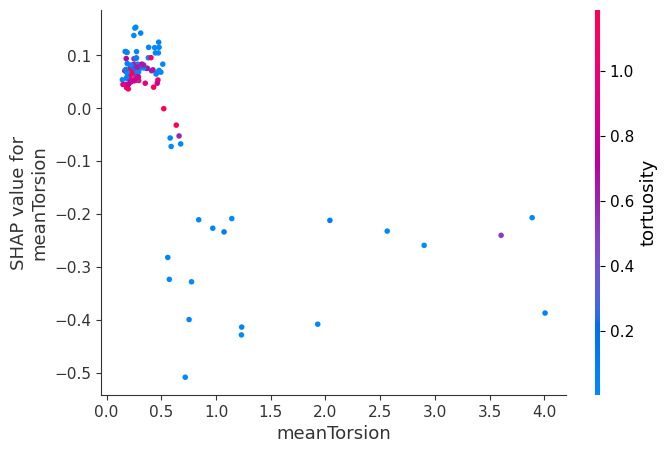

In [127]:
shap.dependence_plot('tortuosity', shap_values.values, X, interaction_index='neckVesselAngle', feature_names=X.columns)
shap.dependence_plot('meanTorsion', shap_values.values, X, interaction_index='tortuosity', feature_names=X.columns)


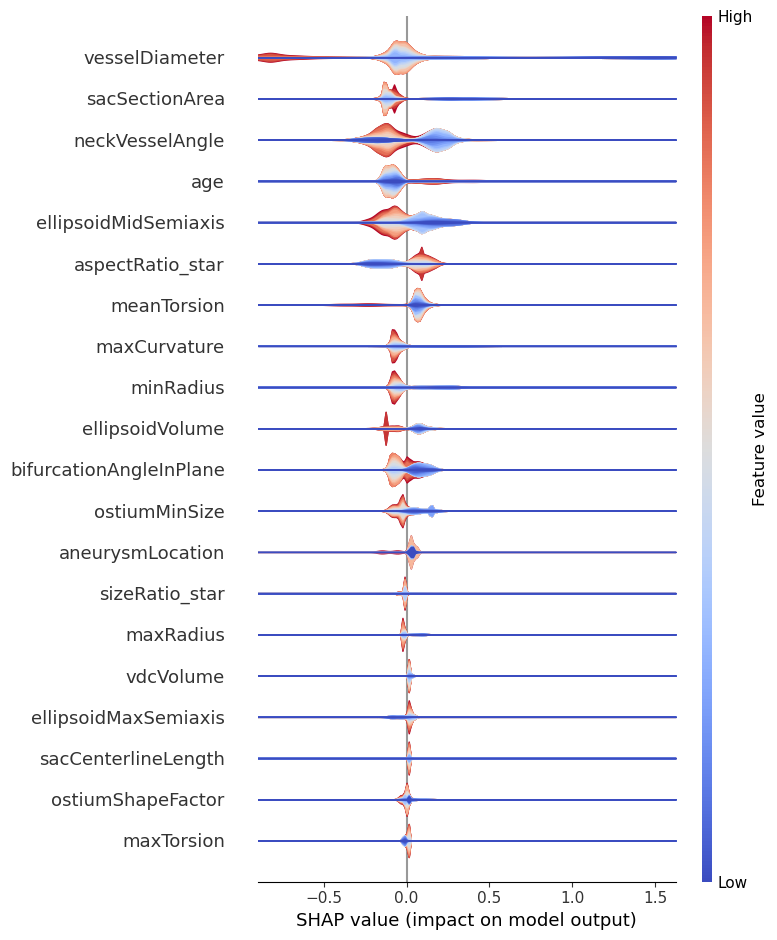

In [128]:
# Display all features in the SHAP summary plot
shap.summary_plot(shap_values.values, features=X, feature_names=X.columns, plot_type="layered_violin")


In [129]:
from skrules import SkopeRules


# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns for rule generation
numeric_columns = original_data.select_dtypes(include=np.number).columns
numeric_data = original_data[numeric_columns]

# Include the cluster labels in the rule generation dataset
numeric_data['Cluster'] = cluster_labels
from sklearn.impute import SimpleImputer

# Impute missing values for numeric data
imputer = SimpleImputer(strategy='mean')  # Use 'mean' to fill missing values
# Drop 'Cluster' before imputation
numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data.drop(columns='Cluster')),
    columns=numeric_data.columns.drop('Cluster')
)

# Reattach the original cluster labels afterward
numeric_data_imputed['Cluster'] = cluster_labels




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [130]:
from skrules import SkopeRules

rules_per_cluster = {}

# Loop through each cluster to generate rules
for cluster in np.unique(cluster_labels):
    print(f"Generating rules for Cluster {cluster}...")
    
    # Create a binary target for the current cluster
    numeric_data_imputed['IsCluster'] = (numeric_data_imputed['Cluster'] == cluster).astype(int)
    
    # Initialize and train SkopeRules
    skope = SkopeRules(max_depth=4, n_estimators=30, precision_min=0.5)
    skope.fit(numeric_data_imputed.drop(columns=['Cluster', 'IsCluster']), numeric_data_imputed['IsCluster'])
    
    # Extract and store the rules
    rules = skope.rules_
    rules_per_cluster[cluster] = rules

# Print the rules for each cluster
for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Rules:")
    for rule in rules:
        print(rule)


Generating rules for Cluster α...
Generating rules for Cluster β...
Generating rules for Cluster γ...

Cluster α Rules:
('__C__18 > 3.0772124528884888 and __C__8 > 1.6103500127792358', (1.0, 1.0, 2))
('__C__18 > 3.0772124528884888 and __C__4 > 35.08999729156494', (1.0, 1.0, 1))
('__C__10 > 3.448447108268738 and __C__18 > 3.083630681037903', (1.0, 1.0, 5))
('__C__18 > 3.083630681037903 and __C__8 > 1.6103500127792358', (1.0, 1.0, 2))
('__C__18 > 3.083630681037903 and __C__7 > 1.9323500394821167', (1.0, 1.0, 1))
('__C__18 > 3.083630681037903 and __C__3 > 22.96495819091797', (1.0, 1.0, 1))
('__C__18 > 3.083630681037903 and __C__6 > 16.73472023010254', (1.0, 1.0, 2))
('__C__18 > 3.0852437019348145 and __C__3 > 22.96495819091797', (1.0, 1.0, 2))
('__C__18 > 3.083630681037903 and __C__5 > 9.30155086517334', (1.0, 1.0, 2))
('__C__18 > 3.0772124528884888 and __C__6 > 16.73472023010254', (1.0, 1.0, 1))
('__C__18 > 3.0852437019348145 and __C__2 > 36.96127891540527', (1.0, 1.0, 1))
('__C__1 > 25.

In [131]:
import re

# Manually define the feature mapping
feature_map = {
    "__C__0": "age",
    "__C__1": "sacVolume",
    "__C__2": "sacSurfaceArea",
    "__C__3": "vdcVolume",
    "__C__4": "vdcSurfaceArea",
    "__C__5": "sacSectionArea",
    "__C__6": "ellipsoidVolume",
    "__C__7": "ellipsoidMaxSemiaxis",
    "__C__8": "ellipsoidMidSemiaxis",
    "__C__9": "ellipsoidMinSemiaxis",
    "__C__10": "sacCenterlineLength",
    "__C__11": "ostiumSectionArea",
    "__C__12": "ostiumSectionPerimeter",
    "__C__13": "ostiumMinSize",
    "__C__14": "ostiumMaxSize",
    "__C__15": "ostiumShapeFactor",
    "__C__16": "aspectRatio_star",
    "__C__17": "sizeRatio_star",
    "__C__18": "vesselDiameter",
    "__C__19": "neckVesselAngle",
    "__C__20": "sacVesselAngle",
    "__C__21": "meanRadius",
    "__C__22": "meanCurvature",
    "__C__23": "meanTorsion",
    "__C__24": "tortuosity",
    "__C__25": "minRadius",
    "__C__26": "maxRadius",
    "__C__27": "maxCurvature",
    "__C__28": "maxTorsion",
    "__C__29": "bifurcationAngleInPlane",
    "__C__30": "bifurcationAngleOutOfPlane"
}

# Function to replace placeholders with feature names using exact matches
def replace_placeholders(rule, feature_map):
    condition, stats = rule
    for placeholder, feature_name in feature_map.items():
        # Use regex to replace exact matches of placeholders only
        condition = re.sub(rf'\b{re.escape(placeholder)}\b', feature_name, condition)
    return f"{condition} (Support: {stats[2]}, Precision: {stats[0]}, Recall: {stats[1]})"

# Replace placeholders for all clusters
for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Mapped Rules:")
    for rule in rules:
        print(replace_placeholders(rule, feature_map))



Cluster α Mapped Rules:
vesselDiameter > 3.0772124528884888 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0772124528884888 and vdcSurfaceArea > 35.08999729156494 (Support: 1, Precision: 1.0, Recall: 1.0)
sacCenterlineLength > 3.448447108268738 and vesselDiameter > 3.083630681037903 (Support: 5, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMaxSemiaxis > 1.9323500394821167 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and vdcVolume > 22.96495819091797 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidVolume > 16.73472023010254 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0852437019348145 and vdcVolume > 22.96495819091797 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.08363068

In [132]:
print(numeric_data_imputed.columns)


Index(['age', 'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'Cluster', 'IsCluster'],
      dtype='object')


In [133]:
print(feature_map)


{'__C__0': 'age', '__C__1': 'sacVolume', '__C__2': 'sacSurfaceArea', '__C__3': 'vdcVolume', '__C__4': 'vdcSurfaceArea', '__C__5': 'sacSectionArea', '__C__6': 'ellipsoidVolume', '__C__7': 'ellipsoidMaxSemiaxis', '__C__8': 'ellipsoidMidSemiaxis', '__C__9': 'ellipsoidMinSemiaxis', '__C__10': 'sacCenterlineLength', '__C__11': 'ostiumSectionArea', '__C__12': 'ostiumSectionPerimeter', '__C__13': 'ostiumMinSize', '__C__14': 'ostiumMaxSize', '__C__15': 'ostiumShapeFactor', '__C__16': 'aspectRatio_star', '__C__17': 'sizeRatio_star', '__C__18': 'vesselDiameter', '__C__19': 'neckVesselAngle', '__C__20': 'sacVesselAngle', '__C__21': 'meanRadius', '__C__22': 'meanCurvature', '__C__23': 'meanTorsion', '__C__24': 'tortuosity', '__C__25': 'minRadius', '__C__26': 'maxRadius', '__C__27': 'maxCurvature', '__C__28': 'maxTorsion', '__C__29': 'bifurcationAngleInPlane', '__C__30': 'bifurcationAngleOutOfPlane'}


In [134]:
for cluster, rules in rules_per_cluster.items():
    print(f"Raw Rules for Cluster {cluster}: {rules}")


Raw Rules for Cluster α: [('__C__18 > 3.0772124528884888 and __C__8 > 1.6103500127792358', (1.0, 1.0, 2)), ('__C__18 > 3.0772124528884888 and __C__4 > 35.08999729156494', (1.0, 1.0, 1)), ('__C__10 > 3.448447108268738 and __C__18 > 3.083630681037903', (1.0, 1.0, 5)), ('__C__18 > 3.083630681037903 and __C__8 > 1.6103500127792358', (1.0, 1.0, 2)), ('__C__18 > 3.083630681037903 and __C__7 > 1.9323500394821167', (1.0, 1.0, 1)), ('__C__18 > 3.083630681037903 and __C__3 > 22.96495819091797', (1.0, 1.0, 1)), ('__C__18 > 3.083630681037903 and __C__6 > 16.73472023010254', (1.0, 1.0, 2)), ('__C__18 > 3.0852437019348145 and __C__3 > 22.96495819091797', (1.0, 1.0, 2)), ('__C__18 > 3.083630681037903 and __C__5 > 9.30155086517334', (1.0, 1.0, 2)), ('__C__18 > 3.0772124528884888 and __C__6 > 16.73472023010254', (1.0, 1.0, 1)), ('__C__18 > 3.0852437019348145 and __C__2 > 36.96127891540527', (1.0, 1.0, 1)), ('__C__1 > 25.015841484069824 and __C__18 > 3.083630681037903', (1.0, 1.0, 1)), ('__C__1 > 25.015

In [135]:
# Rank rules by precision and support
ranked_rules = {}

for cluster, rules in rules_per_cluster.items():
    ranked_rules[cluster] = sorted(
        rules, key=lambda x: (x[1][0], x[1][2]), reverse=True  # Sort by precision, then support
    )

# Display top-ranked rules for each cluster
for cluster, rules in ranked_rules.items():
    print(f"\nTop Rules for Cluster {cluster}:")
    for rule in rules[:5]:  # Display top 5 rules
        print(replace_placeholders(rule, feature_map))



Top Rules for Cluster α:
sacCenterlineLength > 3.448447108268738 and vesselDiameter > 3.083630681037903 (Support: 5, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and sacSurfaceArea > 36.96127891540527 (Support: 4, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0772124528884888 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidVolume > 16.73472023010254 (Support: 2, Precision: 1.0, Recall: 1.0)

Top Rules for Cluster β:
vesselDiameter <= 1.650891900062561 (Support: 34, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.6526591777801514 (Support: 10, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.6143537163734436 (Support: 6, Precision: 1.0, Recall: 0.9273148148148148)
vesselDiameter <= 1.616120994091034 (Support: 5, Precision: 1.0, Recall: 0.9451515151515151)
v

In [136]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict


# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions using cross-validation for the best model
y_pred_prob_best = cross_val_predict(best_model, X_scaled, y_encoded, cv=3, method='predict_proba')[:, 1]

# Calculate AUC-ROC for the best model
auc_roc_best = roc_auc_score(y_encoded, y_pred_prob_best)

# Print the best model's parameters and its AUC-ROC
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
print(f"AUC-ROC Score: {auc_roc_best:.3f}")


`use_label_encoder` is deprecated in 1.7.0.


Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean Cross-Validation Accuracy: 0.709
AUC-ROC Score: 0.714


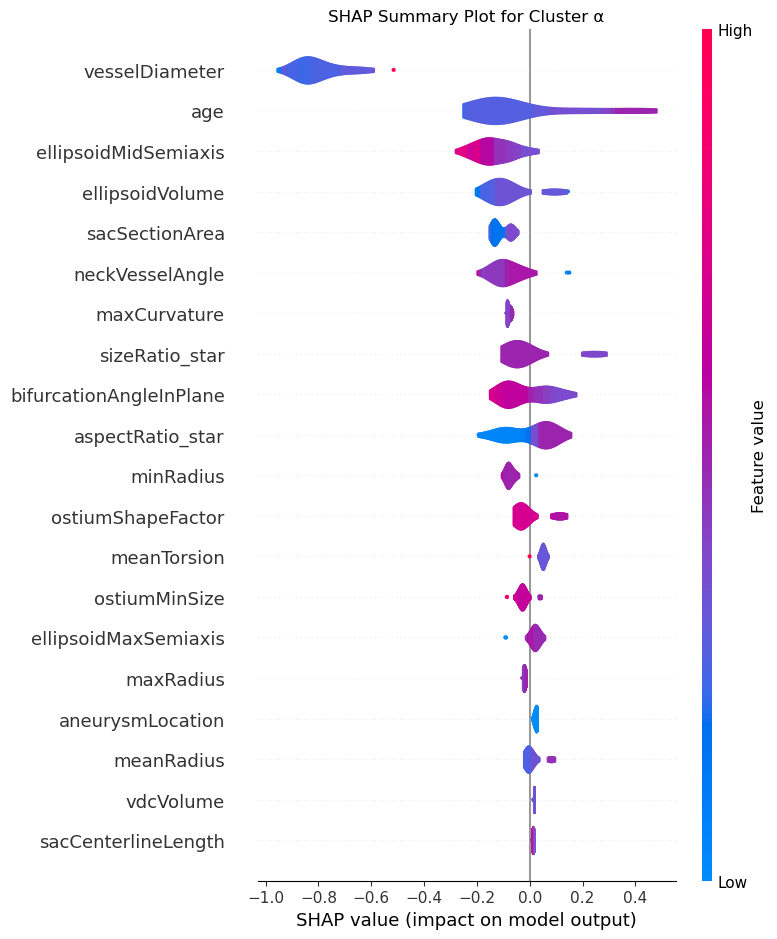

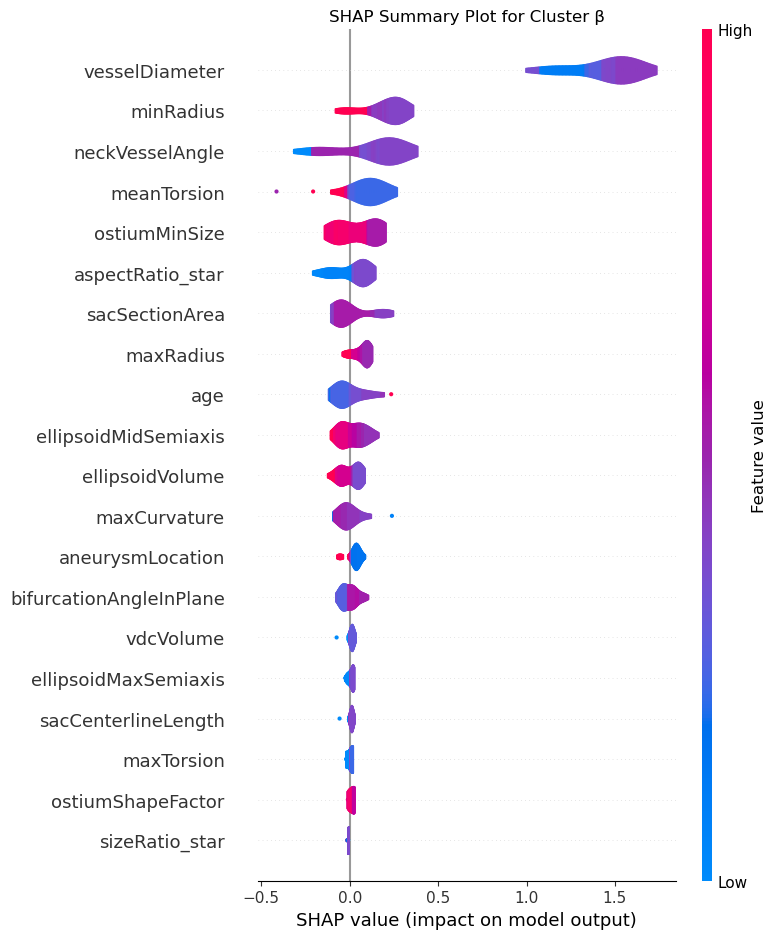

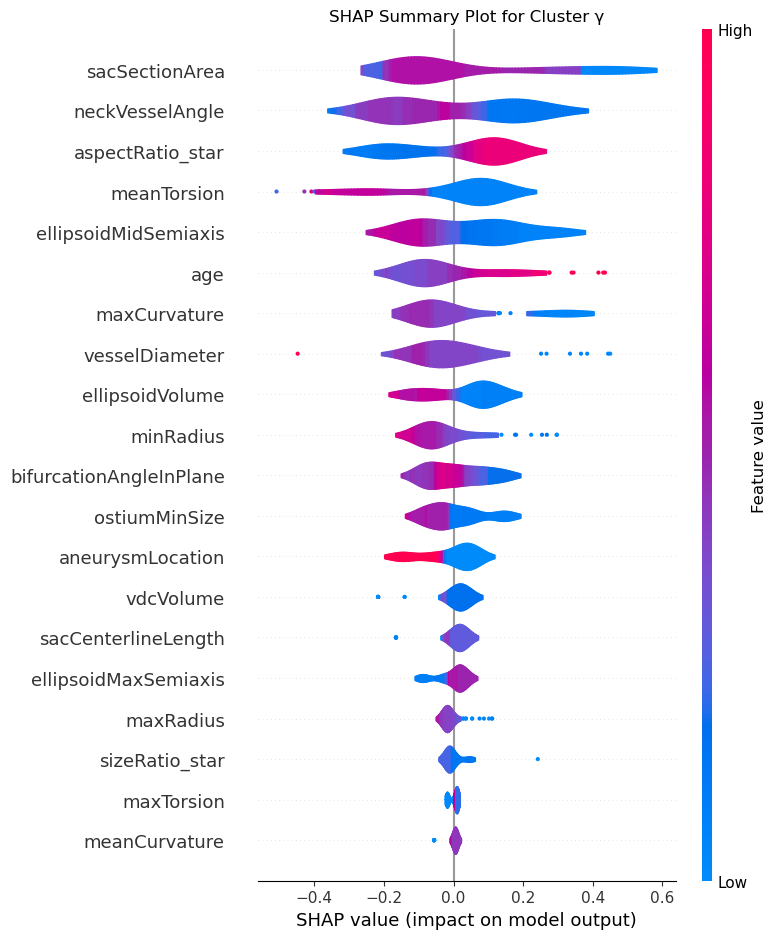

In [137]:
import shap
import matplotlib.pyplot as plt

# Function to plot SHAP summary for a specific cluster
def plot_shap_summary_for_cluster(cluster_label, X_scaled, cluster_labels, shap_values, feature_names):
    # Filter data for the given cluster
    cluster_indices = (cluster_labels == cluster_label)
    X_cluster = X_scaled[cluster_indices]
    shap_values_cluster = shap_values[cluster_indices]

    # Plot SHAP summary for the cluster
    plt.title(f"SHAP Summary Plot for Cluster {cluster_label}")
    shap.summary_plot(shap_values_cluster, X_cluster, feature_names=feature_names, plot_type="violin")

# Loop through each unique cluster and plot SHAP summary
for cluster in sorted(set(cluster_labels)):
    plot_shap_summary_for_cluster(cluster, X_scaled, cluster_labels, shap_values.values, feature_names=X.columns)


In [138]:
print(np.unique(cluster_labels))



['α' 'β' 'γ']


In [139]:
"""print(y_cluster_2.value_counts())
"""

'print(y_cluster_2.value_counts())\n'

In [140]:
from skrules import SkopeRules
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Filter data for Cluster 2
cluster_2_indices = (cluster_labels == 'γ')  # or whichever label corresponds to old Cluster 2
X_cluster_2 = X[cluster_2_indices]
y_cluster_2 = y_encoded[cluster_2_indices]  # Assuming y_encoded represents rupture status (1 = Ruptured, 0 = Unruptured)

# Remove categorical columns
columns_to_remove = ['aneurysmLocation_MCA', 'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType']
X_cluster_2 = X_cluster_2.drop(columns=columns_to_remove)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_cluster_2_imputed = imputer.fit_transform(X_cluster_2)

# Initialize and train SkopeRules
skope = SkopeRules(max_depth=1, n_estimators=30, precision_min=0.5)
skope.fit(X_cluster_2_imputed, y_cluster_2)

# Extract decision rules
rules = skope.rules_

# Display the rules
print("\nDecision Rules for Cluster 2:")
for rule in rules:
    condition, stats = rule
    print(f"Rule: {condition} (Support: {stats[2]}, Precision: {stats[0]}, Recall: {stats[1]})")



Decision Rules for Cluster 2:
Rule: __C__23 <= 0.7077849209308624 (Support: 1, Precision: 0.575, Recall: 0.92)
Rule: __C__23 <= 0.6901670694351196 (Support: 1, Precision: 0.5609756097560976, Recall: 0.9583333333333334)
Rule: __C__19 > 5.879208564758301 (Support: 5, Precision: 0.5345112550107924, Recall: 1.0)
Rule: __C__23 <= 0.5274223387241364 (Support: 1, Precision: 0.5833333333333334, Recall: 0.84)
Rule: __C__23 <= 0.5360501110553741 (Support: 3, Precision: 0.5818318318318318, Recall: 0.8425641025641026)
Rule: __C__19 > 5.768904209136963 (Support: 2, Precision: 0.5108695652173914, Recall: 1.0)
Rule: __C__23 <= 0.6976107060909271 (Support: 4, Precision: 0.5306475029036005, Recall: 0.9157608695652173)
Rule: __C__23 <= 0.7152285575866699 (Support: 1, Precision: 0.5116279069767442, Recall: 0.9166666666666666)
Rule: __C__23 <= 0.7264749109745026 (Support: 1, Precision: 0.5, Recall: 0.9090909090909091)
Rule: __C__14 <= 2.526072382926941 (Support: 1, Precision: 0.5757575757575758, Recall: 

In [141]:

# Extract decision rules
rules = skope.rules_

# Rank rules by precision and support
ranked_rules = sorted(rules, key=lambda x: (x[1][2], x[1][0]), reverse=True)  # Sort by precision, then support

# Display the top-ranked rules
print("\nTop Ranked Decision Rules for Cluster 2:")
for rule in ranked_rules[:5]:  # Display top 5 rules
    print(replace_placeholders(rule, feature_map))


Top Ranked Decision Rules for Cluster 2:
neckVesselAngle > 90.62776947021484 (Support: 9, Precision: 1.0, Recall: 0.13310642658468747)
ellipsoidMidSemiaxis <= 1.5300000309944153 (Support: 5, Precision: 0.6255411255411255, Recall: 0.3327231121281464)
neckVesselAngle > 5.879208564758301 (Support: 5, Precision: 0.5345112550107924, Recall: 1.0)
meanCurvature > 0.17389455437660217 (Support: 4, Precision: 1.0, Recall: 0.15985228539576365)
meanTorsion <= 0.6976107060909271 (Support: 4, Precision: 0.5306475029036005, Recall: 0.9157608695652173)


In [143]:
from skrules import SkopeRules
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Filter data for Cluster 0
cluster_0_indices = (cluster_labels == 'α')
X_cluster_0 = X[cluster_0_indices]
y_cluster_0 = y_encoded[cluster_0_indices]  # Assuming y_encoded represents rupture status (1 = Ruptured, 0 = Unruptured)

# Remove categorical columns
columns_to_remove = ['aneurysmLocation_MCA', 'aneurysmType_TER', 'aneurysmLocation', 'aneurysmType']
X_cluster_0 = X_cluster_0.drop(columns=columns_to_remove)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_cluster_0_imputed = imputer.fit_transform(X_cluster_0)

# Initialize and train SkopeRules
skope = SkopeRules(max_depth=1, n_estimators=30, precision_min=0.5)
skope.fit(X_cluster_0_imputed, y_cluster_0)

# Extract decision rules
rules = skope.rules_

# Display the rules

# Extract decision rules
rules = skope.rules_

# Rank rules by precision and support
ranked_rules = sorted(rules, key=lambda x: (x[1][2], x[1][0]), reverse=True)  # Sort by precision, then support

# Display the top-ranked rules
print("\nTop Ranked Decision Rules for Cluster 0:")
for rule in ranked_rules[:5]:  # Display top 5 rules
    print(replace_placeholders(rule, feature_map))



Top Ranked Decision Rules for Cluster 0:
ostiumMaxSize > 4.777206897735596 (Support: 2, Precision: 0.5, Recall: 1.0)
ostiumSectionArea > 53.476247787475586 (Support: 2, Precision: 0.5, Recall: 1.0)
ostiumSectionPerimeter > 26.6892728805542 (Support: 1, Precision: 0.5, Recall: 1.0)
maxRadius > 3.2211633920669556 (Support: 1, Precision: 0.5, Recall: 1.0)


In [ ]:
# Compile Results with SHAP Values
supervised_clustering_data = pd.DataFrame({
    'Cluster': cluster_labels,
    'f(x)': xgb_model.predict_proba(X_scaled)[:, 1]  # Predicted probabilities for positive class
})

# Add SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
supervised_clustering_data = pd.concat([supervised_clustering_data, shap_values_df], axis=1)

# Add original feature values
feature_values_df = pd.DataFrame(X, columns=X.columns)
supervised_clustering_data = pd.concat([supervised_clustering_data, feature_values_df], axis=1, keys=['SHAP Values', 'Feature Values'])

# Save to CSV
output_path = "supervised_clustering_data_with_shap.csv"
supervised_clustering_data.to_csv(output_path, index=False)

output_path


'supervised_clustering_data_with_shap.csv'

In [ ]:
from skrules import SkopeRules


# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns for rule generation
numeric_columns = original_data.select_dtypes(include=np.number).columns
numeric_data = original_data[numeric_columns]

# Include the cluster labels in the rule generation dataset
numeric_data['Cluster'] = cluster_labels
from sklearn.impute import SimpleImputer


# Ensure the Cluster column is properly aligned
numeric_data_imputed['Cluster'] = cluster_labels


from skrules import SkopeRules

rules_per_cluster = {}

# Loop through each cluster to generate rules
for cluster in np.unique(cluster_labels):
    print(f"Generating rules for Cluster {cluster}...")
    
    # Create a binary target for the current cluster
    numeric_data_imputed['IsCluster'] = (numeric_data_imputed['Cluster'] == cluster).astype(int)
    
    # Initialize and train SkopeRules
    skope = SkopeRules(max_depth=2, n_estimators=30, precision_min=0.5)
    skope.fit(numeric_data_imputed.drop(columns=['Cluster', 'IsCluster']), numeric_data_imputed['IsCluster'])
    
    # Extract and store the rules
    rules = skope.rules_
    rules_per_cluster[cluster] = rules

import re

# Manually define the feature mapping
feature_map = {
    "__C__0": "age",
    "__C__1": "sacVolume",
    "__C__2": "sacSurfaceArea",
    "__C__3": "vdcVolume",
    "__C__4": "vdcSurfaceArea",
    "__C__5": "sacSectionArea",
    "__C__6": "ellipsoidVolume",
    "__C__7": "ellipsoidMaxSemiaxis",
    "__C__8": "ellipsoidMidSemiaxis",
    "__C__9": "ellipsoidMinSemiaxis",
    "__C__10": "sacCenterlineLength",
    "__C__11": "ostiumSectionArea",
    "__C__12": "ostiumSectionPerimeter",
    "__C__13": "ostiumMinSize",
    "__C__14": "ostiumMaxSize",
    "__C__15": "ostiumShapeFactor",
    "__C__16": "aspectRatio_star",
    "__C__17": "sizeRatio_star",
    "__C__18": "vesselDiameter",
    "__C__19": "neckVesselAngle",
    "__C__20": "sacVesselAngle",
    "__C__21": "meanRadius",
    "__C__22": "meanCurvature",
    "__C__23": "meanTorsion",
    "__C__24": "tortuosity",
    "__C__25": "minRadius",
    "__C__26": "maxRadius",
    "__C__27": "maxCurvature",
    "__C__28": "maxTorsion",
    "__C__29": "bifurcationAngleInPlane",
    "__C__30": "bifurcationAngleOutOfPlane"
}

# Function to replace placeholders with feature names using exact matches
def replace_placeholders(rule, feature_map):
    condition, stats = rule
    for placeholder, feature_name in feature_map.items():
        # Use regex to replace exact matches of placeholders only
        condition = re.sub(rf'\b{re.escape(placeholder)}\b', feature_name, condition)
    return f"{condition} (Support: {stats[2]}, Precision: {stats[0]}, Recall: {stats[1]})"

# Replace placeholders for all clusters
for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Mapped Rules:")
    for rule in rules:
        print(replace_placeholders(rule, feature_map))




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster α...
Generating rules for Cluster β...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster γ...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Cluster α Mapped Rules:
sacCenterlineLength > 3.448447108268738 and vesselDiameter > 3.083630681037903 (Support: 2, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and sacSectionArea > 9.606153964996338 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0852437019348145 and sacSurfaceArea > 36.96127891540527 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMaxSemiaxis > 1.8040499687194824 (Support: 4, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.0852437019348145 and ellipsoidVolume > 16.73472023010254 (Support: 1, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and vdcVolume > 22.96495819091797 (Support: 3, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 3, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidVolume > 16.73472023010254 (Support: 2, Precision: 1.0, Recall: 1.0)
ostiumSectionPerimeter > 10.1

In [ ]:
# Rank rules by precision and support
ranked_rules = {}

for cluster, rules in rules_per_cluster.items():   
    ranked_rules[cluster] = sorted(
        rules, key=lambda x: (x[1][0], x[1][2]), reverse=True  # Sort by precision, then support
    )

# Display top-ranked rules for each cluster
for cluster, rules in ranked_rules.items():
    print(f"\nTop Rules for Cluster {cluster}:")
    for rule in rules[:5]:  # Display top 5 rules
        print(replace_placeholders(rule, feature_map))



Top Rules for Cluster α:
vesselDiameter > 3.083630681037903 and ellipsoidMaxSemiaxis > 1.8040499687194824 (Support: 4, Precision: 1.0, Recall: 1.0)
sacVolume > 25.015841484069824 and vesselDiameter > 3.083630681037903 (Support: 4, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and vdcVolume > 22.96495819091797 (Support: 3, Precision: 1.0, Recall: 1.0)
vesselDiameter > 3.083630681037903 and ellipsoidMidSemiaxis > 1.6103500127792358 (Support: 3, Precision: 1.0, Recall: 1.0)
sacCenterlineLength > 3.448447108268738 and vesselDiameter > 3.083630681037903 (Support: 2, Precision: 1.0, Recall: 1.0)

Top Rules for Cluster β:
vesselDiameter <= 1.650891900062561 (Support: 28, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.6526591777801514 (Support: 7, Precision: 1.0, Recall: 1.0)
vesselDiameter <= 1.6143537163734436 (Support: 7, Precision: 1.0, Recall: 0.7214285714285714)
vesselDiameter <= 1.616120994091034 (Support: 2, Precision: 1.0, Recall: 0.7333333333333334)
vesselDiamete